In [1]:
import torch
import torch.nn as nn
from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights

device = 'cuda' if torch.cuda.is_available() else 'cpu'

#https://github.com/zhoubolei/CAM


class Normalize(nn.Module):
    def __init__(self, mean, std) :
        super(Normalize, self).__init__()
        self.register_buffer('mean', torch.Tensor(mean))
        self.register_buffer('std', torch.Tensor(std))
        
    def forward(self, input):
        # Broadcasting
        mean = self.mean.reshape(1, 3, 1, 1)
        std = self.std.reshape(1, 3, 1, 1)
        return (input - mean) / std


norm_layer = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
weights = ResNet50_Weights.DEFAULT


model = resnet50(weights=weights)

model = model.to(device)
if device == 'cuda':
    model = torch.nn.DataParallel(model)

model = model.eval()


In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as T


plt.rcParams["savefig.bbox"] = 'tight'

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False,figsize=(15, 15))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


transform = T.Compose([
    T.Resize((224, 224)),
    T.Normalize(mean=[0, 0, 0], std=[255.0, 255.0, 255.0]),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

process = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        
#img = read_image('images/black_swan.jpeg')
img = read_image('images/macaw.jpg')
batch = transform(img.float()).unsqueeze(0)


In [3]:
batch = batch.to(device)
preprocess = weights.transforms()
prediction = model(batch).squeeze(0).softmax(0)

class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")
print("Top-K labels:",prediction.topk(5)[1].cpu().numpy())


macaw: 44.8%
Top-K labels: [ 88  92 912 634  90]


In [4]:
features_blobs = []
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    
model.module.layer4.register_forward_hook(hook_feature)


In [5]:
# get the softmax weight
import cv2

params = list(model.parameters())
weight_softmax = np.squeeze(params[-2].data.cpu().numpy())

def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 224x224
    size_upsample = (224, 224)
    bz, nc, h, w = feature_conv.shape
    output_cam = []
    for idx in class_idx:
        cam = weight_softmax[idx].dot(feature_conv.reshape((nc, h*w)))
        cam = cam.reshape(h, w)
        cam = cam - np.min(cam)
        cam_img = cam / np.max(cam)
        cam_img = np.uint8(255 * cam_img)
        output_cam.append(cv2.resize(cam_img, size_upsample))
    return output_cam


In [6]:

from torch.nn import functional as F

logit = model(batch)
h_x = F.softmax(logit, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
probs = probs.cpu().numpy()
idx = idx.cpu().numpy()

# generate class activation mapping for the top1 prediction
CAMs = returnCAM(features_blobs[0], weight_softmax, [idx[0]])


In [7]:
resize = T.Resize((224, 224))
imgR = (resize(img.clone().detach()).numpy()).transpose(1,2,0)
height, width, _ = imgR.shape
heatmap = cv2.cvtColor(cv2.applyColorMap(cv2.resize(CAMs[0],(width, height)), cv2.COLORMAP_JET),cv2.COLOR_BGR2RGB)
result = heatmap * 0.4 + imgR * 0.9


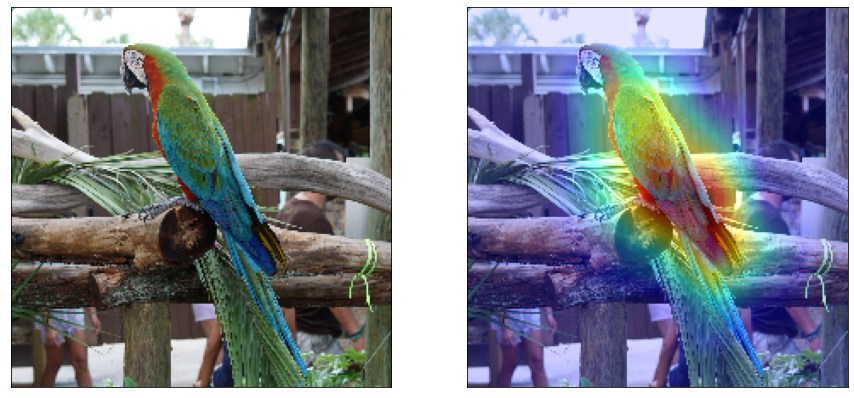

In [8]:
show([torch.tensor(imgR).permute(2, 0, 1),torch.clip(torch.tensor(result/255.0).permute(2, 0, 1),0,1)])